In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import logging
import gensim
import sys

from collections import OrderedDict
from nltk import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from tqdm import tqdm

sys.path.insert(0, '../helper_functions/')
from nlp_preprocessing import (clean_string_fields, get_top_n_grams, get_word_frequency_table)

logging.basicConfig(format='%(asctime)s: %(levelname)s: %(message)s', 
                    datefmt='%Y-%d-%m',
                    level=logging.INFO)

# paths
root_path = '../data_cleaned/'
data_path = f'{root_path}/biorxiv_clean.csv'

In [2]:
df = pd.read_csv(root_path + data_path)

In [3]:
for col in ['abstract', 'title', 'text', 'bibliography']: 
    df[col] = df[col].fillna('unknown').apply(clean_string_fields)

In [7]:
freq_table = get_word_frequency_table(df['abstract'], freq_count=2)

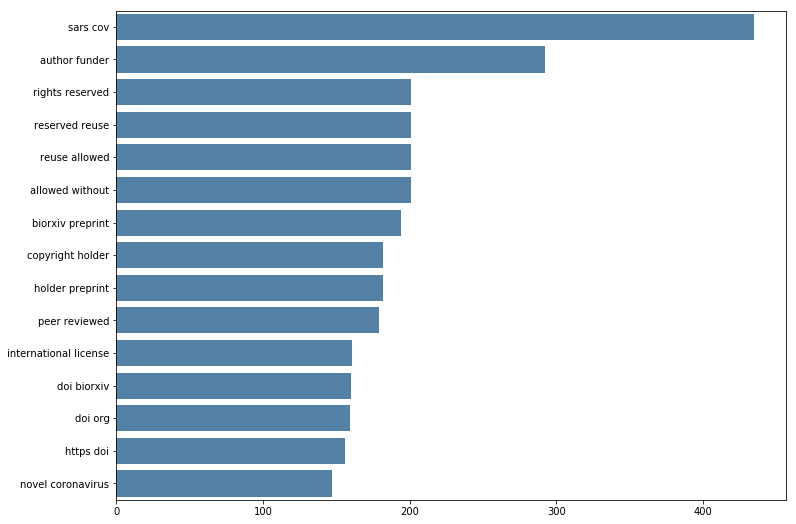

In [9]:
top_n_tri_grams = get_top_n_grams(df['abstract'], n_count=2)[:15]

x, y = map(list, zip(*top_n_tri_grams))
fig, ax = plt.subplots(figsize=(12,9))
sns.barplot(x = y, y = x, color='steelblue', ax=ax)

LDA being a probabilistic graphical model (i.e. dealing with probabilities) only requires raw counts, so we use a CountVectorizer. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

def apply_count_vectorizer(df, series, word_appearal_threshold):
    
    vectorizer = CountVectorizer(max_df=word_appearal_threshold, 
                                 min_df=2, # words that appear in < x lines will be discarded
                                 token_pattern='\w+|\$[\d\.]+|\S+')
    
    tf = vectorizer.fit_transform(df[series]).toarray()

    logging.info(f"applying vectorizer : {vectorizer.get_params()}. \n Matrix shape: {tf.shape}")
    logging.info(f"discard words appearing in more than {word_appearal_threshold}% of cases")
    
    # tf_feature_names tells us what word each column in the matric represents
    tf_feature_names = vectorizer.get_feature_names()
    
    return tf, tf_feature_names

In [13]:
tf, tf_feature_names = apply_count_vectorizer(df=df, series = 'abstract', word_appearal_threshold=.9)

2020-26-03: INFO: applying vectorizer : {'analyzer': 'word', 'binary': False, 'decode_error': 'strict', 'dtype': <class 'numpy.int64'>, 'encoding': 'utf-8', 'input': 'content', 'lowercase': True, 'max_df': 0.9, 'max_features': None, 'min_df': 2, 'ngram_range': (1, 1), 'preprocessor': None, 'stop_words': None, 'strip_accents': None, 'token_pattern': '\\w+|\\$[\\d\\.]+|\\S+', 'tokenizer': None, 'vocabulary': None}. 
 Matrix shape: (803, 6465)
2020-26-03: INFO: discard words appearing in more than 0.9% of cases


### LDA with Sklearn

In [14]:
from sklearn.decomposition import LatentDirichletAllocation

number_of_topics = 10

model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)

model.fit(tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=0, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:
def display_topics(model, feature_names, no_top_words):
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict["Topic %d words" % (topic_idx)]= ['{}'.format(feature_names[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_dict["Topic %d weights" % (topic_idx)]= ['{:.1f}'.format(topic[i])
                        for i in topic.argsort()[:-no_top_words - 1:-1]]
    return pd.DataFrame(topic_dict)

In [16]:
no_top_words = 10
display_topics(model, tf_feature_names, no_top_words)

,Topic 0 words,Topic 0 weights,Topic 1 words,Topic 1 weights,Topic 2 words,Topic 2 weights,Topic 3 words,Topic 3 weights,Topic 4 words,Topic 4 weights,Topic 5 words,Topic 5 weights,Topic 6 words,Topic 6 weights,Topic 7 words,Topic 7 weights,Topic 8 words,Topic 8 weights,Topic 9 words,Topic 9 weights
0,covid,390.1,study,36.0,rna,194.6,patients,274.9,unknown,108.6,rna,117.2,vaccine,67.7,cov,443.9,virus,194.1,model,337.0
1,cases,333.7,quarantine,34.7,protein,126.4,severe,86.1,outbreak,32.6,virus,109.7,cell,66.9,sars,322.0,viral,148.1,transmission,318.7
2,patients,317.7,health,34.3,expression,115.6,preprint,80.5,cases,26.4,using,92.4,protein,56.8,viral,266.0,protein,128.6,data,225.9
3,china,299.4,preprint,33.8,ace,114.3,without,79.1,time,18.6,ibv,88.9,based,48.5,virus,217.5,viruses,124.6,disease,215.4
4,wuhan,252.1,disease,29.3,cells,105.7,ns,77.9,transmission,18.2,viral,83.5,using,47.7,host,210.5,proteins,103.2,population,153.4
5,sars,221.7,license,27.7,cell,93.9,cells,71.8,interval,17.9,used,72.7,epitopes,44.3,coronavirus,192.3,cells,89.4,number,149.5
6,coronavirus,219.6,funder,26.8,gene,90.2,reserved,67.1,model,16.6,samples,68.0,used,40.1,mers,142.2,host,84.6,epidemic,145.8
7,ncov,212.1,author,26.7,virus,88.3,reuse,67.1,estimate,14.6,sequencing,65.3,study,32.9,infection,139.5,preprint,82.7,models,141.7
8,cov,186.2,community,26.0,genes,79.7,allowed,67.0,case,14.4,genes,60.9,also,28.4,human,139.3,doi,82.0,time,134.0
9,outbreak,158.0,hand,25.0,host,72.4,rights,67.0,number,13.8,dna,60.3,specific,27.4,ncov,128.8,genetic,78.0,infection,127.6


### LDA with Gensim

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [20]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim 

In [17]:
def preprocess_news(df, series):
    corpus=[]
    for item in df[series].dropna()[:5000]:
        words=[w for w in word_tokenize(item)]
    
        corpus.append(words)
        
    return corpus

In [18]:
texts = preprocess_news(df, series='abstract')

In [21]:
# Create Dictionary
id2word = corpora.Dictionary(texts)

# Term Document Frequency - TDF
corpus = [id2word.doc2bow(text) for text in texts]

print(f"produced corpus shown above is a mapping of (word_id, word_frequency: {corpus[:1]})")

2020-26-03: INFO: adding document #0 to Dictionary(0 unique tokens: [])
2020-26-03: INFO: built Dictionary(13093 unique tokens: ['ace', 'acute', 'also', 'alterations', 'amylase']...) from 803 documents (total 131769 corpus positions)


produced corpus shown above is a mapping of (word_id, word_frequency: [[(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 2), (21, 5), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 2), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 1), (41, 2), (42, 1), (43, 2), (44, 1), (45, 2), (46, 2), (47, 4), (48, 1), (49, 1), (50, 1), (51, 1), (52, 3), (53, 1), (54, 2), (55, 1), (56, 4), (57, 1), (58, 1), (59, 1), (60, 2), (61, 1), (62, 1), (63, 2), (64, 5), (65, 2), (66, 3), (67, 3), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1)]])


In [23]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10, # training epochs
                                            alpha='auto',
                                            per_word_topics=True)

2020-26-03: INFO: using autotuned alpha, starting with [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]
2020-26-03: INFO: using symmetric eta at 0.1
2020-26-03: INFO: using serial LDA version on this node
2020-26-03: INFO: running online (multi-pass) LDA training, 10 topics, 10 passes over the supplied corpus of 803 documents, updating model once every 100 documents, evaluating perplexity every 803 documents, iterating 50x with a convergence threshold of 0.001000
2020-26-03: INFO: PROGRESS: pass 0, at document #100/803
2020-26-03: INFO: optimized alpha [0.1338661, 0.12558039, 0.10794608, 0.122687474, 0.1293675, 0.12831542, 0.10909651, 0.13532932, 0.13267067, 0.12435893]
2020-26-03: INFO: merging changes from 100 documents into a model of 803 documents
2020-26-03: INFO: topic #2 (0.108): 0.007*"viral" + 0.007*"patients" + 0.006*"sars" + 0.006*"proteins" + 0.006*"virus" + 0.005*"cov" + 0.004*"infection" + 0.004*"vp" + 0.004*"dna" + 0.004*"positive"
2020-26-03: INFO: topic #6 (0.109): 0

In [46]:
# Print the Keyword in the 10 topics
import pprint
pprint.pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

2020-26-03: INFO: topic #0 (0.159): 0.143*"cov" + 0.136*"sars" + 0.023*"early" + 0.015*"protein" + 0.014*"binding" + 0.013*"severe" + 0.012*"associated" + 0.011*"spike" + 0.011*"acute" + 0.011*"syndrome"
2020-26-03: INFO: topic #1 (0.275): 0.085*"data" + 0.026*"using" + 0.025*"virus" + 0.013*"specific" + 0.013*"reveals" + 0.012*"sequencing" + 0.012*"human" + 0.011*"identification" + 0.011*"influenza" + 0.010*"genome"
2020-26-03: INFO: topic #2 (0.120): 0.100*"infect" + 0.091*"diagnosis" + 0.088*"application" + 0.087*"optimization" + 0.033*"rna" + 0.008*"contact" + 0.008*"highly" + 0.007*"epidem" + 0.007*"different" + 0.007*"detect"
2020-26-03: INFO: topic #3 (0.237): 0.053*"period" + 0.052*"analysis" + 0.050*"incubation" + 0.050*"publicly" + 0.049*"statistical" + 0.049*"available" + 0.049*"truncation" + 0.049*"right" + 0.039*"novel" + 0.009*"immune"
2020-26-03: INFO: topic #4 (0.196): 0.092*"control" + 0.029*"cell" + 0.028*"unknown" + 0.021*"cells" + 0.015*"studi" + 0.015*"single" + 0.

[(0,
  '0.143*"cov" + 0.136*"sars" + 0.023*"early" + 0.015*"protein" + '
  '0.014*"binding" + 0.013*"severe" + 0.012*"associated" + 0.011*"spike" + '
  '0.011*"acute" + 0.011*"syndrome"'),
 (1,
  '0.085*"data" + 0.026*"using" + 0.025*"virus" + 0.013*"specific" + '
  '0.013*"reveals" + 0.012*"sequencing" + 0.012*"human" + '
  '0.011*"identification" + 0.011*"influenza" + 0.010*"genome"'),
 (2,
  '0.100*"infect" + 0.091*"diagnosis" + 0.088*"application" + '
  '0.087*"optimization" + 0.033*"rna" + 0.008*"contact" + 0.008*"highly" + '
  '0.007*"epidem" + 0.007*"different" + 0.007*"detect"'),
 (3,
  '0.053*"period" + 0.052*"analysis" + 0.050*"incubation" + 0.050*"publicly" + '
  '0.049*"statistical" + 0.049*"available" + 0.049*"truncation" + '
  '0.049*"right" + 0.039*"novel" + 0.009*"immune"'),
 (4,
  '0.092*"control" + 0.029*"cell" + 0.028*"unknown" + 0.021*"cells" + '
  '0.015*"studi" + 0.015*"single" + 0.014*"expression" + 0.014*"receptor" + '
  '0.011*"molecular" + 0.011*"non"'),
 (5,


### Compute Model Perplexity and Coherence Score

In [25]:
# Compute Perplexity: measure of how good the model is. lower the better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-26-03: INFO: -8.803 per-word bound, 446.5 perplexity estimate based on a held-out corpus of 803 documents with 131769 words
2020-26-03: INFO: using ParallelWordOccurrenceAccumulator(processes=11, batch_size=64) to estimate probabilities from sliding windows



Perplexity:  -8.802658578748202


2020-26-03: INFO: 1 batches submitted to accumulate stats from 64 documents (1654 virtual)
2020-26-03: INFO: 2 batches submitted to accumulate stats from 128 documents (5853 virtual)
2020-26-03: INFO: 3 batches submitted to accumulate stats from 192 documents (9179 virtual)
2020-26-03: INFO: 4 batches submitted to accumulate stats from 256 documents (13783 virtual)
2020-26-03: INFO: 5 batches submitted to accumulate stats from 320 documents (16650 virtual)
2020-26-03: INFO: 6 batches submitted to accumulate stats from 384 documents (21152 virtual)
2020-26-03: INFO: 7 batches submitted to accumulate stats from 448 documents (24918 virtual)
2020-26-03: INFO: 8 batches submitted to accumulate stats from 512 documents (27548 virtual)
2020-26-03: INFO: 9 batches submitted to accumulate stats from 576 documents (32265 virtual)
2020-26-03: INFO: 10 batches submitted to accumulate stats from 640 documents (38980 virtual)
2020-26-03: INFO: 11 batches submitted to accumulate stats from 704 docum


Coherence Score:  0.4419946418908466


### Hyperparameter Tuning

We have a baseline coherence score for the default LDA model, let’s perform a series of sensitivity tests to help determine the following model hyperparameters:

 - Number of Topics (K)
 - Dirichlet hyperparameter alpha: Document-Topic Density
 - Dirichlet hyperparameter beta: Word-Topic Density
 
We’ll perform these tests in sequence, one parameter at a time by keeping others constant and run them over the two different validation corpus sets. We’ll use C_v as our choice of metric for performance comparison

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [28]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpus, 
                                                        texts=texts, 
                                                        start=2, limit=40, step=6)

2020-26-03: INFO: using symmetric alpha at 0.5
2020-26-03: INFO: using symmetric eta at 0.5
2020-26-03: INFO: using serial LDA version on this node
2020-26-03: INFO: running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 803 documents, updating model once every 803 documents, evaluating perplexity every 803 documents, iterating 50x with a convergence threshold of 0.001000
2020-26-03: WARNING: too few updates, training might not converge; consider increasing the number of passes or iterations to improve accuracy
2020-26-03: INFO: -9.916 per-word bound, 966.4 perplexity estimate based on a held-out corpus of 803 documents with 131769 words
2020-26-03: INFO: PROGRESS: pass 0, at document #803/803
2020-26-03: INFO: topic #0 (0.500): 0.006*"patients" + 0.005*"sars" + 0.004*"data" + 0.004*"cases" + 0.004*"preprint" + 0.004*"protein" + 0.004*"cov" + 0.004*"covid" + 0.004*"transmission" + 0.004*"disease"
2020-26-03: INFO: topic #1 (0.500): 0.007*"virus" + 0.0

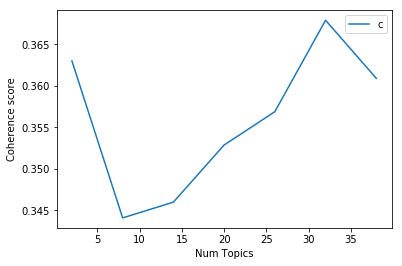

In [29]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [30]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.363
Num Topics = 8  has Coherence Value of 0.3441
Num Topics = 14  has Coherence Value of 0.346
Num Topics = 20  has Coherence Value of 0.3529
Num Topics = 26  has Coherence Value of 0.3569
Num Topics = 32  has Coherence Value of 0.3679
Num Topics = 38  has Coherence Value of 0.3609


In [33]:
# Select the model and print the topics
import pprint
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)
pprint.pprint(optimal_model.print_topics(num_words=10))

2020-26-03: INFO: topic #8 (0.031): 0.007*"patients" + 0.006*"covid" + 0.005*"exon" + 0.004*"severe" + 0.004*"study" + 0.004*"virus" + 0.003*"model" + 0.003*"disease" + 0.003*"viral" + 0.003*"infection"
2020-26-03: INFO: topic #14 (0.031): 0.006*"virus" + 0.005*"data" + 0.005*"cases" + 0.005*"disease" + 0.004*"viruses" + 0.004*"viral" + 0.004*"preprint" + 0.004*"rna" + 0.004*"model" + 0.004*"protein"
2020-26-03: INFO: topic #31 (0.031): 0.009*"protein" + 0.008*"rna" + 0.006*"virus" + 0.005*"cells" + 0.004*"infection" + 0.004*"sequence" + 0.004*"preprint" + 0.004*"cases" + 0.004*"host" + 0.003*"proteins"
2020-26-03: INFO: topic #12 (0.031): 0.007*"virus" + 0.006*"viral" + 0.006*"rna" + 0.004*"viruses" + 0.004*"transmission" + 0.004*"protein" + 0.004*"using" + 0.003*"species" + 0.003*"epidemic" + 0.003*"genome"
2020-26-03: INFO: topic #10 (0.031): 0.006*"covid" + 0.006*"transmission" + 0.005*"patients" + 0.005*"cases" + 0.005*"data" + 0.005*"clinical" + 0.004*"human" + 0.004*"preprint" +

[(8,
  '0.007*"patients" + 0.006*"covid" + 0.005*"exon" + 0.004*"severe" + '
  '0.004*"study" + 0.004*"virus" + 0.003*"model" + 0.003*"disease" + '
  '0.003*"viral" + 0.003*"infection"'),
 (14,
  '0.006*"virus" + 0.005*"data" + 0.005*"cases" + 0.005*"disease" + '
  '0.004*"viruses" + 0.004*"viral" + 0.004*"preprint" + 0.004*"rna" + '
  '0.004*"model" + 0.004*"protein"'),
 (31,
  '0.009*"protein" + 0.008*"rna" + 0.006*"virus" + 0.005*"cells" + '
  '0.004*"infection" + 0.004*"sequence" + 0.004*"preprint" + 0.004*"cases" + '
  '0.004*"host" + 0.003*"proteins"'),
 (12,
  '0.007*"virus" + 0.006*"viral" + 0.006*"rna" + 0.004*"viruses" + '
  '0.004*"transmission" + 0.004*"protein" + 0.004*"using" + 0.003*"species" + '
  '0.003*"epidemic" + 0.003*"genome"'),
 (10,
  '0.006*"covid" + 0.006*"transmission" + 0.005*"patients" + 0.005*"cases" + '
  '0.005*"data" + 0.005*"clinical" + 0.004*"human" + 0.004*"preprint" + '
  '0.004*"cov" + 0.004*"viral"'),
 (25,
  '0.011*"cov" + 0.010*"sars" + 0.010*"v

### Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about.

To find that, we find the topic number that has the highest percentage contribution in that document.

The format_topics_sentences() function below nicely aggregates this information in a presentable table.

In [34]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=df['title']):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    
    return(sent_topics_df)

In [35]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, 
                                                  corpus=corpus, 
                                                  texts=df['title'])

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.8803,"cov, rna, sars, patients, novel, human, virus,...",highly ace expression pancreas may cause pancr...
1,1,4.0,0.9938,"transmission, human, disease, virus, infection...",non uniform refinement adaptive regularization...
2,2,25.0,0.9904,"cov, sars, virus, host, infection, patients, c...",expanding size limit rna viruses evidence nove...
3,3,16.0,0.7159,"number, outbreak, time, data, virus, quarantin...",sequencing human light chain loci hydatidiform...
4,4,0.0,0.0312,"model, patients, based, protein, using, cells,...",self assembly rzz complex filaments drives kin...
5,5,2.0,0.8023,"cases, transmission, ncov, number, viral, mode...",accelerated viral dynamics bat cell lines impl...
6,6,23.0,0.9612,"sars, cov, virus, protein, viral, patients, in...",phylofold precise swift prediction rna seconda...
7,7,8.0,0.7088,"patients, covid, exon, severe, study, virus, m...",quantitative framework define end outbreak app...
8,8,27.0,0.5155,"virus, model, data, patients, disease, china, ...",airway irf versus irf molecular response patte...
9,9,15.0,0.9640,"patients, cases, transmission, disease, data, ...",human bocavirus prevalence children acute gast...


### Topic distribution across documents

In [36]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,1.0,"cov, rna, sars, patients, novel, human, virus,...",48.0,0.0598
1.0,4.0,"transmission, human, disease, virus, infection...",11.0,0.0137
2.0,25.0,"cov, sars, virus, host, infection, patients, c...",47.0,0.0585
3.0,16.0,"number, outbreak, time, data, virus, quarantin...",24.0,0.0299
4.0,0.0,"model, patients, based, protein, using, cells,...",9.0,0.0112
5.0,2.0,"cases, transmission, ncov, number, viral, mode...",33.0,0.0411
6.0,23.0,"sars, cov, virus, protein, viral, patients, in...",9.0,0.0112
7.0,8.0,"patients, covid, exon, severe, study, virus, m...",16.0,0.0199
8.0,27.0,"virus, model, data, patients, disease, china, ...",16.0,0.0199
9.0,15.0,"patients, cases, transmission, disease, data, ...",8.0,0.0100
